In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import joblib, os

sys.path.append('../')

from TS_model.vizualization import PerformEDA
from TS_model.automl_tuning import ModelSelector

from TS_model.anomaly_detector import AnomalyDetector
from TS_model.breakpoints_detector import ChangeFinder

%load_ext autoreload  
%autoreload 2

In [2]:
data = pd.read_excel('../Project 2_2023.xlsx', parse_dates=True, index_col=0)
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.144836
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.796823
4,2017-01-13,0.955924,0.975645,-0.019721


In [3]:
# Применение Isolation Forest для обнаружения аномалий
anomaly_detector_iforest = AnomalyDetector(contamination=0.05)
anomaly_detector_iforest.fit(data)
anomalies_iforest = anomaly_detector_iforest.detect(data)
clean_data_iforest = anomaly_detector_iforest.remove_anomalies(data)

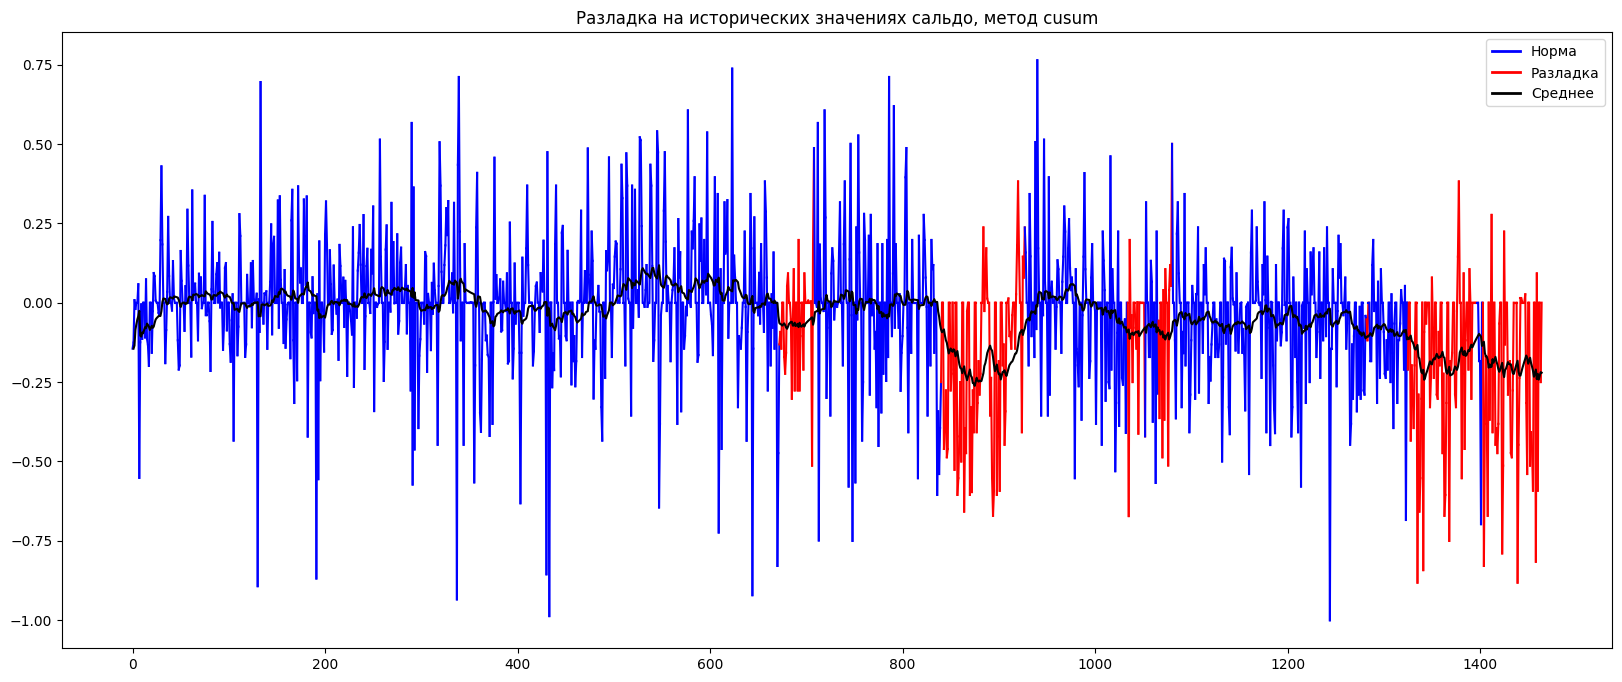

In [4]:
# Инициализация CUSUM-детектора
# параметры подобраны визуально по графику
cm = ChangeFinder(alpha=0.05, beta=0.005, method='cusum', mean_diff=-0.01, 
                              trsh=0.06, slice_length=5, breaks_max=3)
ChangeFinder.plot(clean_data_iforest,cm, method='cusum')

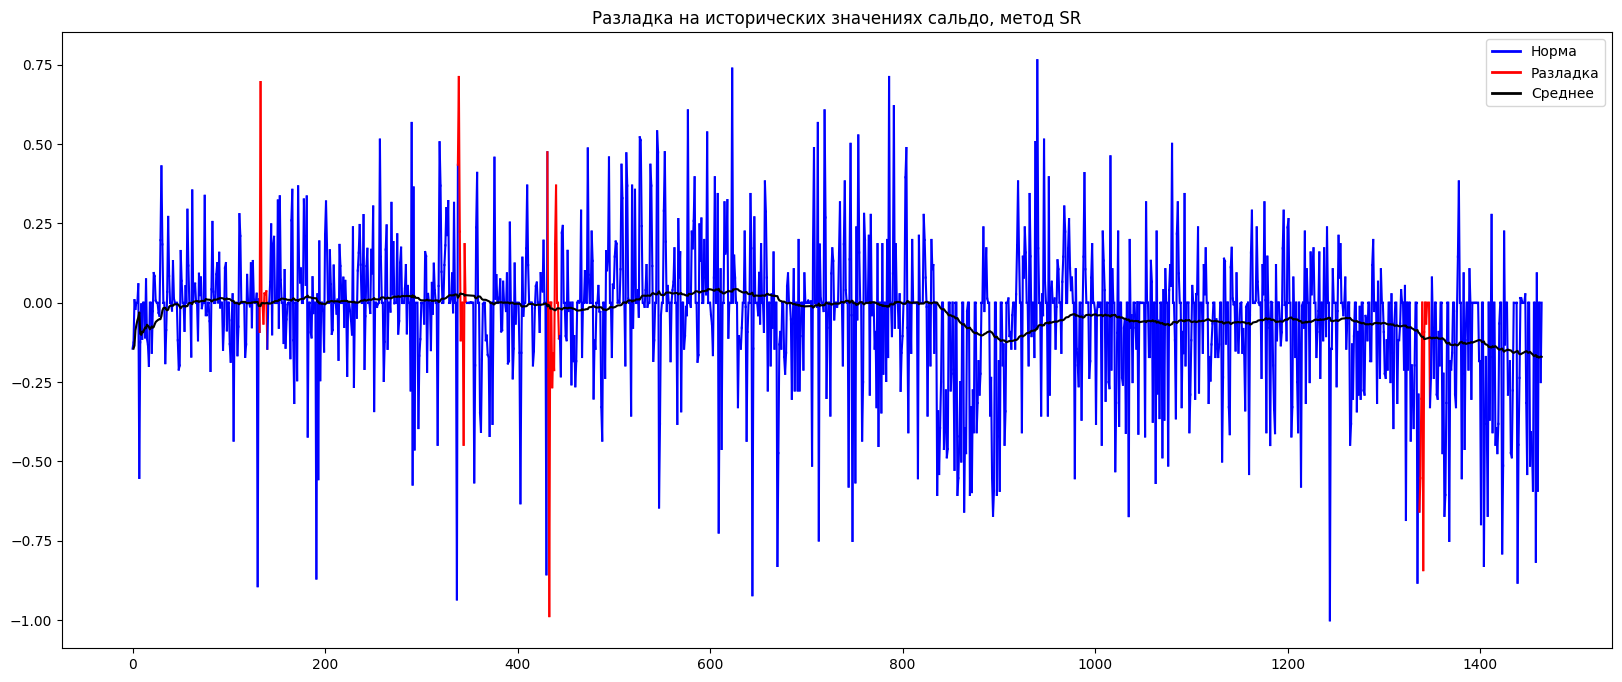

In [5]:
# Инициализация SR-детектора
# параметры подобраны визуально по графику
cr = ChangeFinder(alpha=0.01, beta=0.07, method='sr', sigma_diff = 0.5, ceil=100,
                              trsh=10, slice_length=10, breaks_max=2)
ChangeFinder.plot(clean_data_iforest,cr, method='SR')

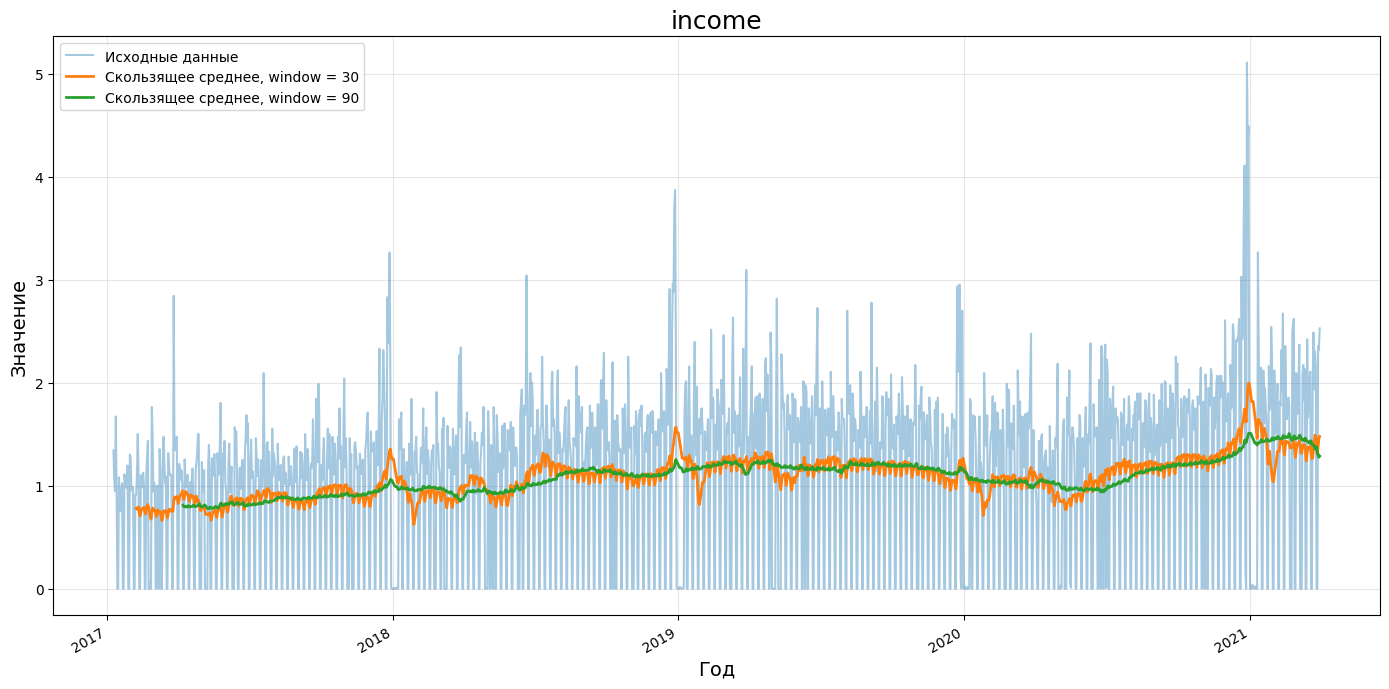

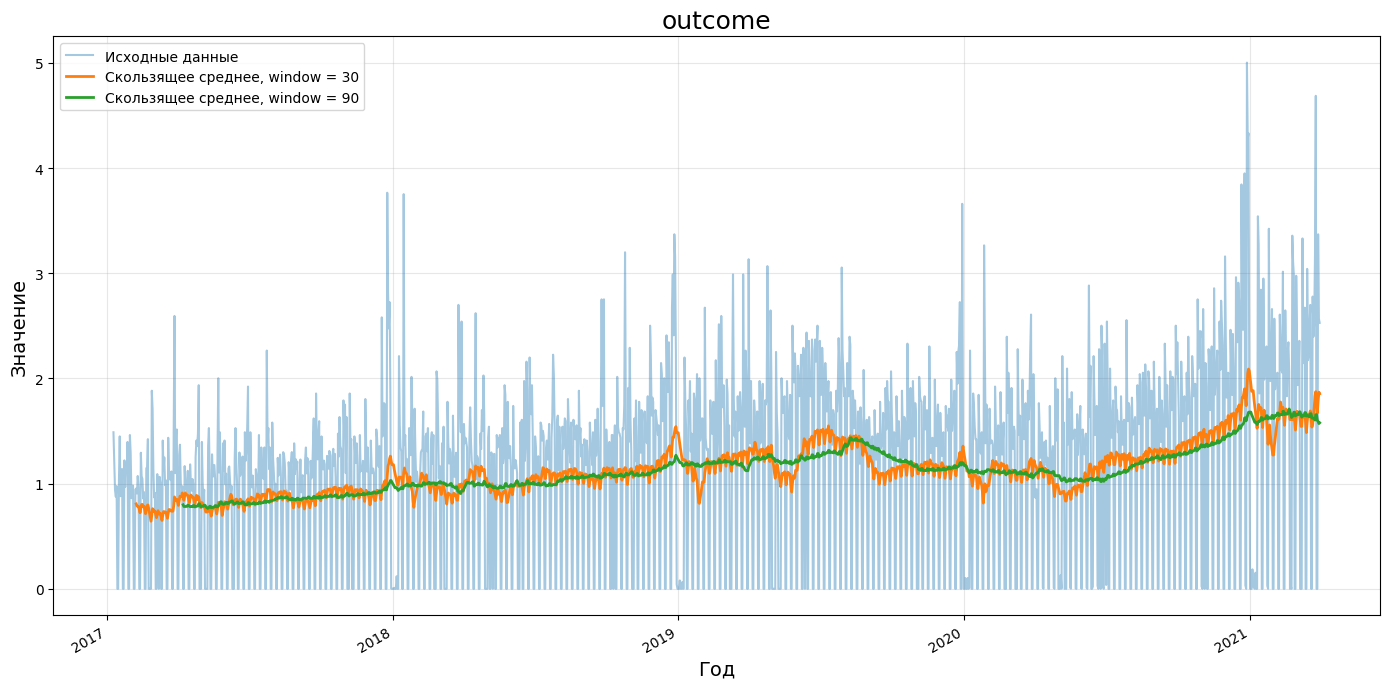

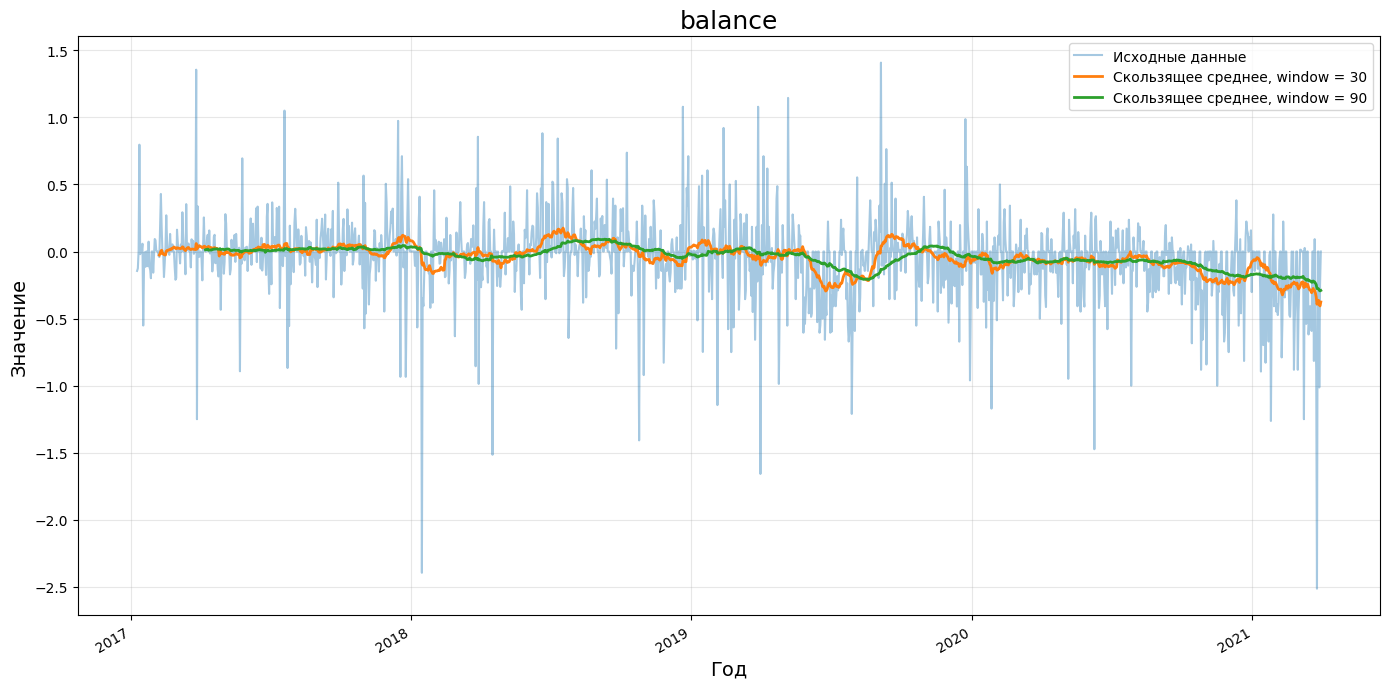

In [6]:
for col in data.copy().drop(['date'], axis=1).columns:
    PerformEDA(data=data).vizualize_var(col, windows=[30, 90])

### Модель (расчет MAE на исторических данных)

In [ ]:
data = pd.read_excel('../Data/chosen_features.xlsx', index_col=0)
x, y = data.drop('balance', axis=1), data['balance']

In [ ]:
x_train, y_train, x_test, y_test = x.iloc[0:-1], y.iloc[0:-1], x.iloc[[-1]], y.iloc[[-1]]

In [12]:
x_train.columns

Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
       'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
       'balance_ma3', 'income_ma3', 'outcome_ma3', 'balance_ma7', 'income_ma7',
       'outcome_ma7', 'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
       'day_of_week_cos', 'month_sin', 'month_cos', 'dow_0', 'close',
       'usd_rate'],
      dtype='object')

In [13]:
# примерные данные для показа работы модели
horizon = 10                    
x_train, y_train = x.iloc[:-horizon], y.iloc[:-horizon]
x_test,  y_test  = x.iloc[-horizon:], y.iloc[-horizon:]

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA

def fallback_model_training(model_cls=GradientBoostingRegressor, data_path='../Data/chosen_features.xlsx', target_col = "balance", confirm = True, **model_kwargs):
    """
    Обучает пользовательскую модель при переходе на ручное управление. Если есть model — используем ее. Иначе создаём model_cls(**model_kwargs). По умолчанию GradientBoostingRegressor
    """
    df = pd.read_excel(data_path)
    df.drop('date', inplace=True, axis=1)
    y = df[target_col]
    x = df.drop(columns=target_col)
    model = model_cls(**model_kwargs)

    print('\n ВНИМАНИЕ!  Вы собираетесь обучить пользовательскую модель:')
    print(f'Класс модели: {model.__class__.__name__}')
    print(f'x.shape = {x.shape}, y.shape = {y.shape}')
    print('-------------------------------------------------------------')

    if confirm:
        proceed = input("Нажмите <Enter>, чтобы начать обучение, или 'q' для отмены: ")
        if proceed.lower().startswith('q'):
            raise RuntimeError('Обучение пользовательской модели отменено оператором') # на случай того, если в ручном режиме хочется использовать экзотическую модель  и переписать класс

    model.fit(x, y)
    preds = model.predict(x)
    mae = mean_absolute_error(y, preds)
    print(f'✅ Пользовательская модель обучена. MAE (train) = {mae:.4f}')
    return model

In [ ]:
trigger_1 = False  # переобучение, если concept_drift
trigger_2 = True  # перевод в ручное управление, если аномалии

MODEL_PATH = 'model.pkl'
TODAY       = pd.Timestamp.today().tz_localize(None)
# Если первый день месяца, то переобучаем модельку
FIRST_DAY   = TODAY.day == 1

if trigger_2:
    # жёсткий отказ от AutoML → берём свою модель 
    model = fallback_model_training()
    print('Используем пользовательскую модель (fallback)')

elif trigger_1 or FIRST_DAY or not os.path.exists(MODEL_PATH):
    # нужно переобучить AutoML и сохранить - time_budget(время обучения)
    x_train.insert(0, 'date', x_train.index)
    model = ModelSelector(time_budget=300 * 12, metric='mae').find_best_model(x_train, y_train, period=1)
    joblib.dump(model, MODEL_PATH)
    print('Переобучили AutoML')

else:
    # всё норм, используем уже обученный AutoML
    x_train.insert(0, 'date', x_train.index)
    model = joblib.load(MODEL_PATH)
    print('Загрузили существующую модель')


 ВНИМАНИЕ!  Вы собираетесь обучить пользовательскую модель:
Класс модели: GradientBoostingRegressor
x.shape = (1095, 28), y.shape = (1095,)
-------------------------------------------------------------
✅ Пользовательская модель обучена. MAE (train) = 0.1554
Используем пользовательскую модель (fallback)


In [19]:
if trigger_2:
    prediction = model.predict(x_test)
else:
    x_test.insert(0, 'date', x_test.index)
    prediction = model.predict(x_test)

In [20]:
abs_errors = (y_test.values - prediction).ravel().astype(float).__abs__()
print('Ошибки по каждой точке:', abs_errors.tolist())
print('Среднее MAE:', abs_errors.mean())

Ошибки по каждой точке: [0.010243954327754434, 0.12726462688848622, 0.05560894871616684, 0.32762535280358795, 0.06420080323374555, 0.17038204093952614, 0.282434558385146, 0.20555984702413377, 0.07664824467408216, 0.22322205034981774]
Среднее MAE: 0.15431904273424468
